## Detectron2 Training

**Set the following variables, and run all.**

The notebook reports COCO eval metrics and visualizations at the end.

`img_dir`: location of all images (both training and test)

`train_json`: COCO annotation file consisting of training set annotations 

`test_json`: COCO annotation file consisting of test / validation set annotations

`dataset_name`: a name for the dataset, for detectron2 bookkeeping

In [1]:
img_dir = '/home/locobotm/AVD/habitat_data_with_seg/rgb/'
train_json = '/home/locobotm/AVD/habitat_data_with_seg/train.json'
# train_json = 'habitat_sem_annot3.json' # label prop train data
test_json = '/home/locobotm/AVD/habitat_data_with_seg/test.json'
dataset_name = 'habitat_1'

In [2]:
import torchvision

# import some common libraries
import numpy as np
import sys
if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')

import cv2
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
import random
import os
import numpy as np
import json

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2.config import CfgNode as CN
from detectron2.data import DatasetCatalog, MetadataCatalog

import random
import torch 
import base64
import io
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from ast import literal_eval
from PIL import Image

pd.set_option('max_colwidth', 300)

import glob
from IPython.core.display import display, HTML

pd.set_option('max_colwidth', 300)
matplotlib.rcParams['figure.figsize'] = (20, 7.0)

display(HTML(
    """
    <style>
    .container { width:100% !important; }
    #notebook { letter-spacing: normal !important;; }
    .CodeMirror { font-family: monospace !important; }
    .cm-keyword { font-weight: bold !important; color: #008000 !important; }
    .cm-comment { font-style: italic !important; color: #408080 !important; }
    .cm-operator { font-weight: bold !important; color: #AA22FF !important; }
    .cm-number { color: #080 !important; }
    .cm-builtin { color: #008000 !important; }
    .cm-string { color: #BA2121 !important; }
    </style>
    """
))


Bad key text.latex.unicode in file /home/locobotm/anaconda3/envs/locobot_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file /home/locobotm/anaconda3/envs/locobot_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key pgf.debug in file /home/locobotm/anaconda3/envs/locobot_env/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 444 ('pgf.debug           : False')
You proba

## Detectron2 Setup

In [3]:
DatasetCatalog.clear()
MetadataCatalog.clear()
train_data = dataset_name +  "_train"
val_data = dataset_name + "_val"
from detectron2.data.datasets import register_coco_instances
register_coco_instances(train_data, {}, train_json, img_dir)
register_coco_instances(val_data, {}, test_json, img_dir)

from detectron2.data import DatasetMapper, build_detection_train_loader

MetadataCatalog.get(train_data)

namespace(name='habitat_1_train',
          json_file='/home/locobotm/AVD/habitat_data_with_seg/train.json',
          image_root='/home/locobotm/AVD/habitat_data_with_seg/rgb/',
          evaluator_type='coco')

## Visualizing the dataset

[03/12 15:20:02 d2.data.datasets.coco]: Loaded 120 images in COCO format from /home/locobotm/AVD/habitat_data_with_seg/train.json


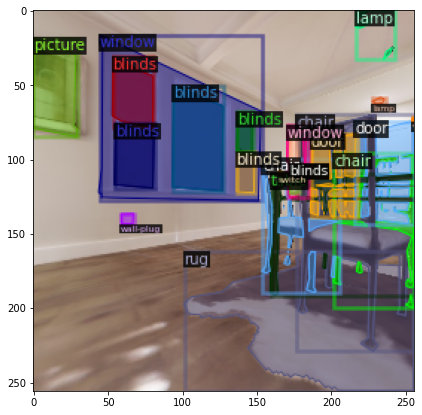

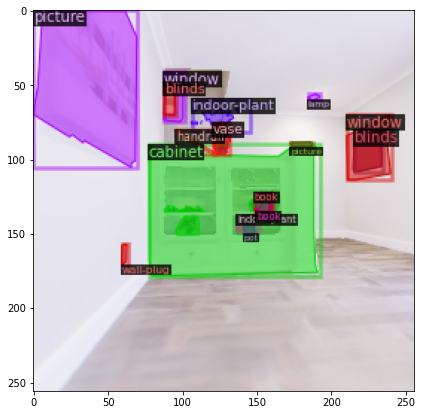

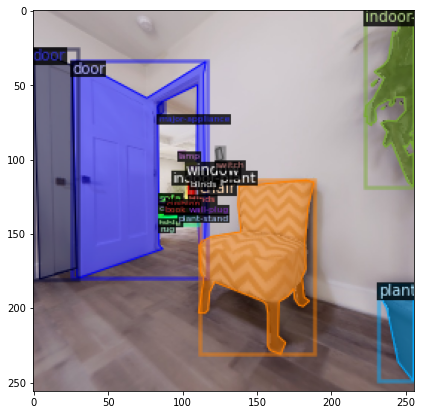

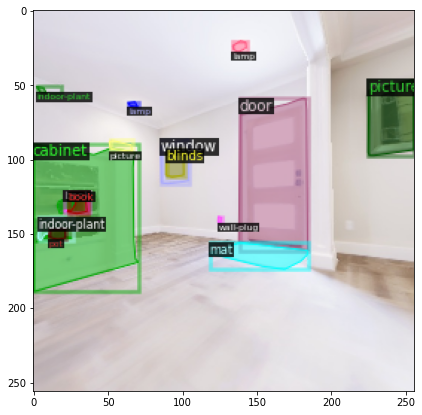

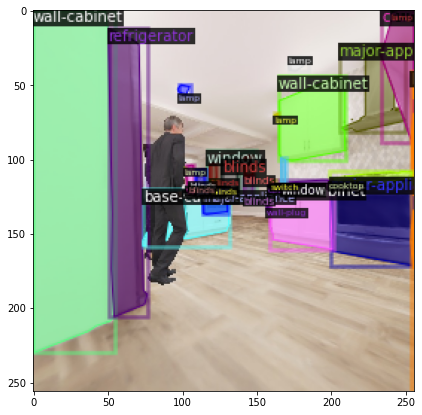

In [4]:
import random

dataset_dicts = DatasetCatalog.get(train_data)

for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=MetadataCatalog.get(train_data), scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    img = vis.get_image()
    plt.imshow(img)
    plt.show()

In [5]:
coco_yaml = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
lvis_yaml = "LVIS-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml"
lvis_yaml2 = "LVIS-InstanceSegmentation/mask_rcnn_R_101_FPN_1x.yaml"
pano_yaml = "COCO-PanopticSegmentation/panoptic_fpn_R_50_3x.yaml"

In [6]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(coco_yaml))
cfg.DATASETS.TRAIN = (train_data,)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(coco_yaml)  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.005  # pick a good LR
cfg.SOLVER.MAX_ITER = 500 
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128 
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(MetadataCatalog.get(train_data).get("thing_classes"))  # only has one class (ballon)

## Training

In [7]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

[03/12 15:20:06 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (102, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (102,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (404, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (404,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (101, 256

[03/12 15:20:08 d2.engine.train_loop]: Starting training from iteration 0


/home/locobotm/anaconda3/envs/locobot_env/lib/python3.7/site-packages/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/home/locobotm/anaconda3/envs/locobot_env/lib/python3.7/site-packages/detectron2/structures/masks.py:345: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629427478/work/torch/csrc/utils/python_arg_parser.cpp:766.)
  item = item.nonzero().squeeze(1).cpu().numpy().tolist()
/home/locobotm/anaconda3/envs/locobot_env/lib/python3.7/site-packages/detectron2/layers/wrappers.py:240: UserWarning: This overload of nonze

[03/12 15:20:13 d2.utils.events]:  eta: 0:01:40  iter: 19  total_loss: 7.93  loss_cls: 4.505  loss_box_reg: 0.82  loss_mask: 0.6928  loss_rpn_cls: 1.235  loss_rpn_loc: 0.3937  time: 0.2079  data_time: 0.0145  lr: 9.9905e-05  max_mem: 1869M
[03/12 15:20:17 d2.utils.events]:  eta: 0:01:37  iter: 39  total_loss: 4.145  loss_cls: 1.836  loss_box_reg: 0.7013  loss_mask: 0.6821  loss_rpn_cls: 0.2061  loss_rpn_loc: 0.415  time: 0.2100  data_time: 0.0039  lr: 0.0001998  max_mem: 1869M
[03/12 15:20:21 d2.utils.events]:  eta: 0:01:33  iter: 59  total_loss: 3.784  loss_cls: 1.531  loss_box_reg: 0.8114  loss_mask: 0.6706  loss_rpn_cls: 0.1809  loss_rpn_loc: 0.5588  time: 0.2101  data_time: 0.0041  lr: 0.0002997  max_mem: 1869M
[03/12 15:20:25 d2.utils.events]:  eta: 0:01:29  iter: 79  total_loss: 3.324  loss_cls: 1.344  loss_box_reg: 0.7639  loss_mask: 0.6372  loss_rpn_cls: 0.1152  loss_rpn_loc: 0.4418  time: 0.2103  data_time: 0.0038  lr: 0.00039961  max_mem: 1869M
[03/12 15:20:30 d2.utils.events

Reusing TensorBoard on port 6006 (pid 25189), started 7 days, 16:17:27 ago. (Use '!kill 25189' to kill it.)

## Evaluation

In [8]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator(val_data, ("bbox", "segm"), False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, val_data)
print(inference_on_dataset(trainer.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[03/12 15:22:06 d2.data.datasets.coco]: Loaded 30 images in COCO format from /home/locobotm/AVD/habitat_data_with_seg/test.json
[03/12 15:22:06 d2.data.build]: Distribution of instances among all 101 categories:
|   category    | #instances   |   category    | #instances   |   category    | #instances   |
|:-------------:|:-------------|:-------------:|:-------------|:-------------:|:-------------|
|   backpack    | 0            | base-cabinet  | 30           |    basket     | 16           |
|    bathtub    | 0            |     beam      | 0            |    beanbag    | 0            |
|      bed      | 0            |     bench     | 0            |     bike      | 0            |
|      bin      | 0            |    blanket    | 0            |    blinds     | 86           |
|     book      | 23           |    bottle     | 4            |      box      | 0            |
|     bowl      | 0            |    camera     | 0            |    cabinet    | 5            |
|    candle     | 0         

[03/12 15:22:10 d2.data.datasets.coco]: Loaded 30 images in COCO format from /home/locobotm/AVD/habitat_data_with_seg/test.json
/home/locobotm/AVD/habitat_data_with_seg/rgb/00120.jpg


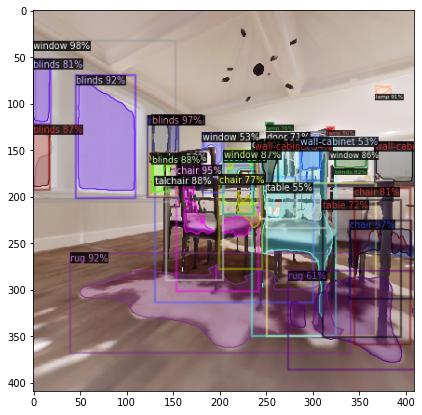

/home/locobotm/AVD/habitat_data_with_seg/rgb/01500.jpg


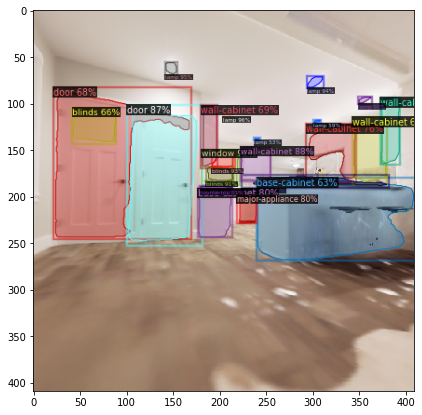

/home/locobotm/AVD/habitat_data_with_seg/rgb/01620.jpg


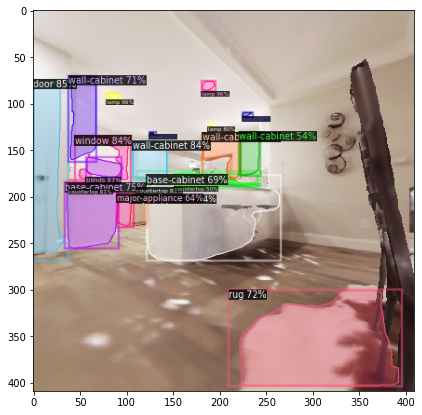

/home/locobotm/AVD/habitat_data_with_seg/rgb/01680.jpg


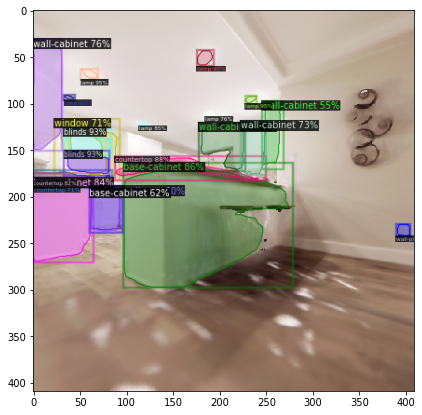

/home/locobotm/AVD/habitat_data_with_seg/rgb/02040.jpg


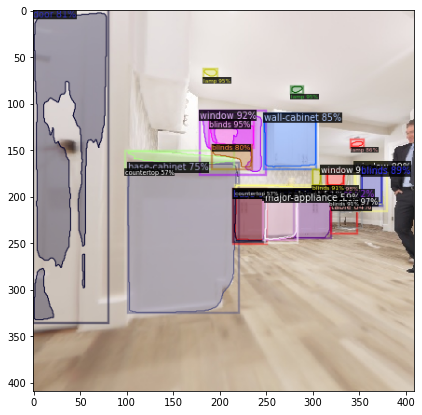

In [9]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = (val_data, )
predictor = DefaultPredictor(cfg)


def visualize(filename):
    im = cv2.imread(filename)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get(val_data), 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image())
    plt.show()

for d in DatasetCatalog.get(val_data)[:5]:
    print(d['file_name'])
    visualize(d['file_name'])
